# Vision models

## Orientation: ResNet-18


1. Let's start by training a simple ResNet-18 model and take lots of checkpoints.
2. Then do feature visualization on the end results (for a random sample of neurons). 
3. Look at how the activation of the target neuron reacts to those feature visualizations over the course of training.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.utils as vutils
from PIL import Image
from tqdm.notebook import tqdm
import os
from dataclasses import dataclass, field
from typing import Optional, Container, Tuple, List, Dict
from dataclasses import asdict
import math
import numpy as np

from dotenv import load_dotenv
load_dotenv("../.env")


True

In [2]:
torch.manual_seed(0)
model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /home/paperspace/.cache/torch/hub/pytorch_vision_v0.10.0
/home/paperspace/Projects/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/Projects/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
@dataclass
class Config:
    batch_size: int = 128
    lr: float = 0.01  # Starting lr
    weight_decay: float = 0.0001
    num_epochs: Optional[int] = None
    logging_steps: Optional[Container] = None
    project: Optional[str] = None
    entity: Optional[str] = None
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    betas: Tuple[float, float] = (0.9, 0.999)

    def __post_init__(self):
        if self.num_epochs is None:
            # Default to 64k steps
            self.num_epochs = 64000 * self.batch_size // len(train_set)

        if self.logging_steps is None or isinstance(self.logging_steps, int):
            logging_steps = self.logging_steps
            # By default: 1x per epoch
            self.logging_steps = set([i * len(train_set) // self.batch_size for i in range(self.num_epochs)]) 

            if isinstance(logging_steps, int):
                # Logscale from with self.logging_steps steps between 0 and num_epochs * len(train_data) // self.batch_size
                self.logging_steps |= {int(i) for i in np.logspace(0, np.log10(self.num_epochs * len(train_set) // self.batch_size), logging_steps)}
                
config = Config(project="resnet18", entity="devinterp", logging_steps=100)
steps = sorted(list(config.logging_steps))
config

Config(batch_size=128, lr=0.01, weight_decay=0.0001, num_epochs=163, logging_steps={0, 1, 37890, 2, 3, 4, 23046, 5, 6, 60937, 7, 8203, 8, 46093, 9, 10, 11, 521, 31250, 13, 14, 16, 16406, 18, 54296, 20, 1562, 22, 25, 39453, 28, 31, 24609, 35, 62500, 9765, 1019, 39, 47656, 32812, 44, 3117, 17968, 49, 14897, 55859, 3125, 41015, 55, 1594, 26171, 62, 11328, 49218, 36418, 69, 34375, 583, 19531, 57421, 78, 4687, 42578, 27734, 87, 12890, 50781, 35937, 97, 21093, 58984, 6250, 56939, 44140, 109, 29296, 1140, 14453, 52343, 122, 37500, 22656, 60546, 7812, 45703, 136, 11914, 30859, 652, 16015, 53906, 1171, 39062, 152, 24218, 62109, 6814, 9375, 47265, 32421, 17578, 170, 55468, 2734, 40625, 25781, 2229, 63670, 10937, 48828, 190, 33984, 19140, 18628, 57031, 4296, 42187, 27343, 12500, 213, 50390, 729, 35546, 20703, 58593, 5859, 2787, 43750, 50920, 28906, 14062, 238, 51953, 37109, 1783, 22265, 1275, 60156, 7421, 23292, 45312, 30468, 4358, 15625, 4873, 53515, 266, 781, 38671, 16658, 40723, 23828, 61718, 

In [ ]:
def maybe_initialize_wandb(project_name: Optional[str] = None, entity: Optional[str] = None):
    if project_name:
        import wandb
        wandb.init(project=project_name, entity=entity)
        return wandb
    return None

wandb = maybe_initialize_wandb(config.project, config.entity)

In [5]:
from torch.optim.lr_scheduler import MultiStepLR
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, betas=config.betas)
scheduler = MultiStepLR(optimizer, milestones=[16_000, 32_000, 48_000], gamma=0.5) 

torch.manual_seed(1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=config.batch_size, shuffle=False)

In [6]:
import logging
import boto3
from botocore.exceptions import ClientError
import os


s3_client = boto3.client('s3')

def upload_file(file_name, bucket_name = 'devinterp', object_name=None):

    if object_name is None:
        object_name = file_name
    s3_client.upload_file(file_name, bucket_name, object_name)


In [7]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, scheduler, logging_steps: set,device: torch.device, num_epochs=10, project="resnet18", **kwargs):
    model.train()

    # Calculate total number of batches
    num_batches_per_epoch = len(train_loader)
    total_batches = num_batches_per_epoch * num_epochs

    pbar = tqdm(total=total_batches, desc=f"Epoch 0 Batch 0/{total_batches} Loss: ?.??????")
    
    for epoch in range(1, num_epochs + 1):
        for _batch_idx, (data, target) in enumerate(train_loader, 1):  # Start batch_idx from 1
            batch_idx = num_batches_per_epoch * epoch + _batch_idx
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Update progress bar description
            pbar.set_description(f"Epoch {epoch} Batch {batch_idx}/{total_batches} Loss: {loss.item():.6f}")
            pbar.update(1)
            
            if wandb:
                wandb.log({"Batch/Loss": loss.item()}, step=batch_idx)

            # Log to wandb & save checkpoints according to log_steps
            if batch_idx in logging_steps:
                checkpoint_name = f"../checkpoints/{project}/{get_checkpoint_id(epoch, batch)}.pt"
                torch.save(model.state_dict(), checkpoint_name)
                upload_file(checkpoint_name)
                os.remove(checkpoint_name)
        
        pbar.close()
    
    if wandb:
        wandb.finish()


In [ ]:
train(model, train_loader, optimizer, scheduler, **asdict(config))

# Feature visualization

We have a trained `model` (and a bunch of checkpoints). First, let's do some classic feature visualization on the final network. We'll select a few random neurons from ac

In [8]:
from typing import Union
import warnings


class CheckpointManager:
    def __init__(self, project_name: str, bucket_name = 'devinterp'):
        self.project_name = project_name
        self.bucket_name = bucket_name
        self.checkpoints = self.get_checkpoints(self.bucket_name)

    @classmethod
    def get_checkpoints(cls, bucket_name: str) -> List[Tuple[int, int]]:
        """
        Returns a list of tuples (epoch, batch_idx) of all checkpoints in the bucket.
        """
        response = s3_client.list_objects_v2(Bucket=bucket_name)

        if 'Contents' in response:
            return sorted([cls.decode_checkpoint_id(item['Key']) for item in response['Contents']])

        warnings.warn("No files found in the bucket.")
        return []
    
    @staticmethod
    def get_checkpoint_id(epoch: int, batch_idx: int) -> str:
        return f"checkpoint_epoch_{epoch}_batch_{batch_idx}"

    @classmethod
    def get_checkpoint_path(cls, epoch: int, batch_idx: int, project_name: str) -> str:
        return f"../checkpoints/{project_name}/{cls.get_checkpoint_id(epoch, batch_idx)}.pt"

    @staticmethod
    def decode_checkpoint_id(checkpoint_id: str) -> Tuple[int, int]:
        parts = checkpoint_id.split("_")
        epoch = int(parts[-3])
        batch_idx = int(parts[-1].split(".")[0])
        return epoch, batch_idx

    @classmethod
    def load_checkpoint(cls, epoch: int, batch_idx: int, bucket_name: str, project_name: str) -> Dict:
        s3_client = boto3.client('s3')

        file_name = cls.get_checkpoint_path(epoch, batch_idx, project_name)
        object_name = os.path.basename(file_name)        

        print(f"Downloading {object_name} from {bucket_name}...")
        s3_client.download_file(bucket_name, object_name, file_name)

        state_dict = torch.load(file_name)
        os.remove(file_name)

        return state_dict

    def __iter__(self):
        for checkpoint in self.checkpoints:
            yield self.load_checkpoint(*checkpoint, self.bucket_name, self.project_name)

    def __len__(self):
        return len(self.checkpoints)

    def __getitem__(self, idx: Union[int, tuple]):
        if isinstance(idx, int):
            return self.load_checkpoint(*self.checkpoints[idx], self.bucket_name, self.project_name)

        elif isinstance(idx, tuple):
            if idx not in self.checkpoints:
                warnings.warn(f"Checkpoint {idx} not found in {self.bucket_name}.")

            return self.load_checkpoint(*idx, self.bucket_name, self.project_name)

        raise TypeError(f"Invalid argument type: {type(idx)}")

    def __contains__(self, checkpoint: Tuple[int, int]):
        return checkpoint in self.checkpoints

    def __repr__(self):
        return f"CheckpointManager({self.project_name}, {self.bucket_name})"    

checkpoints = CheckpointManager('resnet18', 'devinterp')


In [9]:
model = torchvision.models.resnet18(pretrained=False)
model.load_state_dict(checkpoints[-1])
# model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v1', pretrained=True)
model.state_dict().keys()

/home/paperspace/Projects/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/Projects/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

class ActivationExtractor:
    """
    With this version, you can use the ActivationExtractor with the following location formats:

    - 'layer1.0.conv1.weight.3': Only channel is specified; y and x default to center.
    - 'layer1.0.conv1.weight.3.2': Channel and y are specified; x defaults to center.
    - 'layer1.0.conv1.weight.3..2': Channel and x are specified; y defaults to center.
    - 'layer1.0.conv1.weight.3.2.2': Channel, y, and x are all specified.
    
    """
    
    def __init__(self, model, location):
        self.activation = None
        self.model = model
        self.location = location.split('.')
        self.layer_path = []
        self.channel = None
        self.y = None
        self.x = None

        # Split the location into layer path and neuron indices
        state_dict_keys = list(model.state_dict().keys())
        for part in self.location:
            self.layer_path.append(part)
            path = '.'.join(self.layer_path)
            
            if any(key.startswith(path) for key in state_dict_keys):
                continue
            else:
                self.layer_path.pop()
                self.channel, *yx = map(int, self.location[len(self.layer_path):])
                if yx:
                    self.y = yx[0]
                    if len(yx) > 1:
                        self.x = yx[1]
                break

        # Get the target layer
        self.layer = model
        for part in self.layer_path[:-1]:
            self.layer = getattr(self.layer, part)

    def hook_fn(self, module, input, output):
        y = self.y if self.y is not None else output.size(2) // 2
        x = self.x if self.x is not None else output.size(3) // 2

        self.activation = output[0, self.channel, y, x]

    def register_hook(self):
        handle = self.layer.register_forward_hook(self.hook_fn)
        return handle


def gen_image(image: torch.Tensor):
    # Process the optimized input
    image = image.detach().cpu().squeeze(0)

    image -= image.min()
    image /= image.max()

    # Create grid
    grid_image = vutils.make_grid([image], nrow=1)

    # Convert to numpy and transpose for plotting
    grid_image_np = grid_image.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

    return grid_image_np

def show_image(image: torch.Tensor):
    # Convert to numpy and transpose for plotting
    grid_image_np = gen_image(image)

    # Display using matplotlib
    plt.figure(figsize=(5, 5))  # You can change the size as you prefer
    plt.imshow(grid_image_np)
    plt.axis('off') # to remove the axis
    plt.show()

def show_images(*images: torch.Tensor, **kwargs):
    # Normalize images to [0,1] and create grid
    images = [img - img.min() for img in images]
    images = [img / img.max() for img in images]
    images = [img.squeeze(0) for img in images]
    
    # Create grid
    grid_image = vutils.make_grid(images, nrow=len(images))

    # Convert to numpy and transpose for plotting
    grid_image_np = grid_image.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

    # Display using matplotlib
    plt.figure(figsize=(15, 30), **kwargs)  # You can change the size as you prefer
    plt.imshow(grid_image_np)
    plt.axis('off') # to remove the axis
    plt.show()


def add_jitter(input_image, jitter_amount=2):
    """Applies jitter by randomly shifting the image."""
    if not jitter_amount:
        return input_image

    x_shift, y_shift = torch.randint(jitter_amount, -jitter_amount, (2,))
    return torch.roll(input_image, shifts=(x_shift, y_shift), dims=(2, 3))

def render(model: nn.Module, location: str, thresholds: list[int]=[512], verbose: bool = True, seed: int = 0, device: str = torch.device) -> tuple[list[torch.Tensor], float]:
    # Assuming 'model' is your pre-trained ResNet model and 'location' is the string specifying the neuron's location
    model.to(device)
    model = model.eval()
    extractor = ActivationExtractor(model, location)
    handle = extractor.register_hook()

    # Create a random image (1x3x224x224) to start optimization, with same size as typical ResNet input
    torch.manual_seed(seed)
    input_image = torch.rand((1, 3, 32, 32), requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([input_image], lr=0.01, weight_decay=1e-3)
    jitter_amount = 0

    final_images = []

    # Optimization loop
    pbar = range(max(thresholds) + 1)

    if verbose:
        pbar = tqdm(pbar, desc=f"Visualizing {location} (activation: ???)")

    for iteration in pbar:
        optimizer.zero_grad()
        model(input_image)  # Forward pass through the model to trigger the hook
        activation = extractor.activation
        loss = -activation  # Maximizing activation
        loss.backward()
        optimizer.step()

        input_image.data = add_jitter(input_image.data.detach().clone(), jitter_amount=-jitter_amount)

        if verbose:
            pbar.set_description(f"Visualizing {location} (activation: {activation.item():.2f})")

        if iteration in thresholds:
            # if verbose:
            #     show_image(input_image)

            image = input_image.detach().clone()
            image = torch.reshape(image, (1, 3, 32, 32))            
            final_images.append(image)

    handle.remove()  # Remove the hook after the loop

    return final_images, extractor.activation.item()


def render_multiple(model: nn.Module, *locations: str, thresholds: list[int]=[512], verbose: bool = True, init_seed: int = 0, device: str = "cuda", **kwargs) -> list[tuple[list[torch.Tensor], float]]:
    results = []

    for i, location in enumerate(locations):
        images, activation = render(
            model, 
            location = location,
            thresholds = thresholds,
            verbose = verbose,
            seed=init_seed + i,
            device=device
        )

        if verbose: 
            show_images(*images, **kwargs)

        results.append((images, activation))

    return results

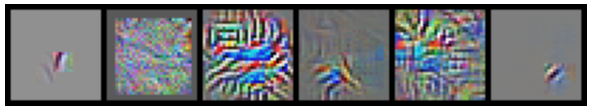

In [24]:
results = render_multiple(
    model,    
    'layer1.0.conv1.weight.0',
    'layer1.0.conv2.weight.1',
    'layer1.1.conv1.weight.7',
    'layer1.1.conv2.weight.4',
    'layer2.0.conv1.weight.3',
    'layer2.0.conv2.weight.2',
    thresholds=[0, 64, 128, 256, 512],
    verbose=False,
    device="cuda:0"
)
show_images(*[images[-1] for (images, _) in results], dpi=50)

### Maximally active neurons

Let's go through all neurons in the model and rank them by their activation. We will then plot the top 10 most active neurons.

In [22]:
from torch.nn import Conv2d

def gen_conv_neurons(model: nn.Module):
    """Generate convolutional neurons from a PyTorch model."""
    channel_locations = []

    def recursive_search(module, prefix):
        for name, submodule in module.named_children():
            path = prefix + '.' + name if prefix else name

            # Check if the submodule is a convolutional layer
            if isinstance(submodule, Conv2d):
                # Generate locations for all channels in this convolutional layer
                for channel in range(submodule.out_channels):
                    location = f"{path}.weight.{channel}"
                    channel_locations.append(location)

            # Recursively search through children
            recursive_search(submodule, path)

    recursive_search(model, '')

    return channel_locations

conv_neurons = gen_conv_neurons(model)[64:]
print(conv_neurons)

['layer1.0.conv1.weight.0', 'layer1.0.conv1.weight.1', 'layer1.0.conv1.weight.2', 'layer1.0.conv1.weight.3', 'layer1.0.conv1.weight.4', 'layer1.0.conv1.weight.5', 'layer1.0.conv1.weight.6', 'layer1.0.conv1.weight.7', 'layer1.0.conv1.weight.8', 'layer1.0.conv1.weight.9', 'layer1.0.conv1.weight.10', 'layer1.0.conv1.weight.11', 'layer1.0.conv1.weight.12', 'layer1.0.conv1.weight.13', 'layer1.0.conv1.weight.14', 'layer1.0.conv1.weight.15', 'layer1.0.conv1.weight.16', 'layer1.0.conv1.weight.17', 'layer1.0.conv1.weight.18', 'layer1.0.conv1.weight.19', 'layer1.0.conv1.weight.20', 'layer1.0.conv1.weight.21', 'layer1.0.conv1.weight.22', 'layer1.0.conv1.weight.23', 'layer1.0.conv1.weight.24', 'layer1.0.conv1.weight.25', 'layer1.0.conv1.weight.26', 'layer1.0.conv1.weight.27', 'layer1.0.conv1.weight.28', 'layer1.0.conv1.weight.29', 'layer1.0.conv1.weight.30', 'layer1.0.conv1.weight.31', 'layer1.0.conv1.weight.32', 'layer1.0.conv1.weight.33', 'layer1.0.conv1.weight.34', 'layer1.0.conv1.weight.35', '

['layer1.0.conv1.weight.0', 'layer1.0.conv1.weight.1', 'layer1.0.conv1.weight.2', 'layer1.0.conv1.weight.3', 'layer1.0.conv1.weight.4', 'layer1.0.conv1.weight.5', 'layer1.0.conv1.weight.6', 'layer1.0.conv1.weight.7', 'layer1.0.conv1.weight.8', 'layer1.0.conv1.weight.9']


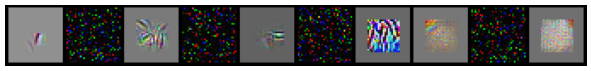

Saving results at 0
[('layer1.0.conv1.weight.6', 361.2734375), ('layer1.0.conv1.weight.4', 0.057205066084861755), ('layer1.0.conv1.weight.9', 0.02868860401213169), ('layer1.0.conv1.weight.2', 0.0071949223056435585), ('layer1.0.conv1.weight.7', 0.004194531124085188), ('layer1.0.conv1.weight.0', 0.00012343437992967665), ('layer1.0.conv1.weight.3', 8.449872605331067e-22), ('layer1.0.conv1.weight.8', 1.0702066696664709e-39), ('layer1.0.conv1.weight.1', 1.0333511187562639e-39), ('layer1.0.conv1.weight.5', -1.9021431775963148e-17)]
['layer1.0.conv1.weight.10', 'layer1.0.conv1.weight.11', 'layer1.0.conv1.weight.12', 'layer1.0.conv1.weight.13', 'layer1.0.conv1.weight.14', 'layer1.0.conv1.weight.15', 'layer1.0.conv1.weight.16', 'layer1.0.conv1.weight.17', 'layer1.0.conv1.weight.18', 'layer1.0.conv1.weight.19']


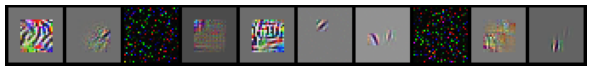

['layer1.0.conv1.weight.20', 'layer1.0.conv1.weight.21', 'layer1.0.conv1.weight.22', 'layer1.0.conv1.weight.23', 'layer1.0.conv1.weight.24', 'layer1.0.conv1.weight.25', 'layer1.0.conv1.weight.26', 'layer1.0.conv1.weight.27', 'layer1.0.conv1.weight.28', 'layer1.0.conv1.weight.29']


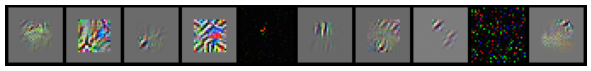

['layer1.0.conv1.weight.30', 'layer1.0.conv1.weight.31', 'layer1.0.conv1.weight.32', 'layer1.0.conv1.weight.33', 'layer1.0.conv1.weight.34', 'layer1.0.conv1.weight.35', 'layer1.0.conv1.weight.36', 'layer1.0.conv1.weight.37', 'layer1.0.conv1.weight.38', 'layer1.0.conv1.weight.39']


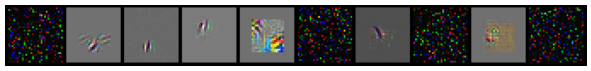

['layer1.0.conv1.weight.40', 'layer1.0.conv1.weight.41', 'layer1.0.conv1.weight.42', 'layer1.0.conv1.weight.43', 'layer1.0.conv1.weight.44', 'layer1.0.conv1.weight.45', 'layer1.0.conv1.weight.46', 'layer1.0.conv1.weight.47', 'layer1.0.conv1.weight.48', 'layer1.0.conv1.weight.49']


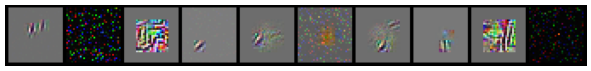

['layer1.0.conv1.weight.50', 'layer1.0.conv1.weight.51', 'layer1.0.conv1.weight.52', 'layer1.0.conv1.weight.53', 'layer1.0.conv1.weight.54', 'layer1.0.conv1.weight.55', 'layer1.0.conv1.weight.56', 'layer1.0.conv1.weight.57', 'layer1.0.conv1.weight.58', 'layer1.0.conv1.weight.59']


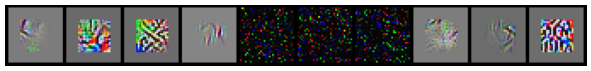

['layer1.0.conv1.weight.60', 'layer1.0.conv1.weight.61', 'layer1.0.conv1.weight.62', 'layer1.0.conv1.weight.63', 'layer1.0.conv2.weight.0', 'layer1.0.conv2.weight.1', 'layer1.0.conv2.weight.2', 'layer1.0.conv2.weight.3', 'layer1.0.conv2.weight.4', 'layer1.0.conv2.weight.5']


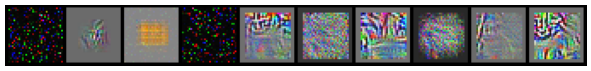

['layer1.0.conv2.weight.6', 'layer1.0.conv2.weight.7', 'layer1.0.conv2.weight.8', 'layer1.0.conv2.weight.9', 'layer1.0.conv2.weight.10', 'layer1.0.conv2.weight.11', 'layer1.0.conv2.weight.12', 'layer1.0.conv2.weight.13', 'layer1.0.conv2.weight.14', 'layer1.0.conv2.weight.15']


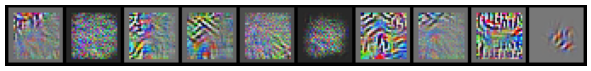

['layer1.0.conv2.weight.16', 'layer1.0.conv2.weight.17', 'layer1.0.conv2.weight.18', 'layer1.0.conv2.weight.19', 'layer1.0.conv2.weight.20', 'layer1.0.conv2.weight.21', 'layer1.0.conv2.weight.22', 'layer1.0.conv2.weight.23', 'layer1.0.conv2.weight.24', 'layer1.0.conv2.weight.25']


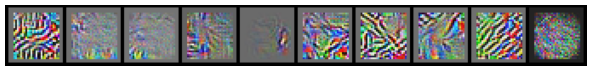

['layer1.0.conv2.weight.26', 'layer1.0.conv2.weight.27', 'layer1.0.conv2.weight.28', 'layer1.0.conv2.weight.29', 'layer1.0.conv2.weight.30', 'layer1.0.conv2.weight.31', 'layer1.0.conv2.weight.32', 'layer1.0.conv2.weight.33', 'layer1.0.conv2.weight.34', 'layer1.0.conv2.weight.35']


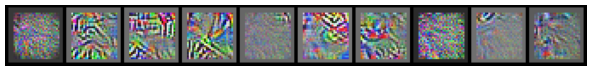

['layer1.0.conv2.weight.36', 'layer1.0.conv2.weight.37', 'layer1.0.conv2.weight.38', 'layer1.0.conv2.weight.39', 'layer1.0.conv2.weight.40', 'layer1.0.conv2.weight.41', 'layer1.0.conv2.weight.42', 'layer1.0.conv2.weight.43', 'layer1.0.conv2.weight.44', 'layer1.0.conv2.weight.45']


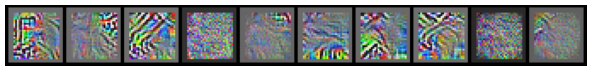

Saving results at 100
[('layer1.0.conv2.weight.16', 1935.83154296875), ('layer1.0.conv2.weight.24', 1690.9774169921875), ('layer1.0.conv2.weight.38', 1636.090576171875), ('layer1.0.conv1.weight.42', 1523.22119140625), ('layer1.0.conv2.weight.12', 1468.628173828125), ('layer1.0.conv1.weight.52', 1333.0986328125), ('layer1.0.conv1.weight.10', 1326.197021484375), ('layer1.0.conv1.weight.14', 1316.9493408203125), ('layer1.0.conv1.weight.51', 1268.247802734375), ('layer1.0.conv1.weight.23', 1258.9888916015625), ('layer1.0.conv2.weight.22', 1208.8236083984375), ('layer1.0.conv2.weight.5', 1177.46533203125), ('layer1.0.conv2.weight.21', 1137.974609375), ('layer1.0.conv2.weight.14', 1015.3340454101562), ('layer1.0.conv2.weight.29', 953.989990234375), ('layer1.0.conv2.weight.28', 798.8133544921875), ('layer1.0.conv1.weight.21', 701.4945068359375), ('layer1.0.conv2.weight.36', 682.5035400390625), ('layer1.0.conv2.weight.27', 681.3707275390625), ('layer1.0.conv2.weight.42', 664.84814453125), ('la

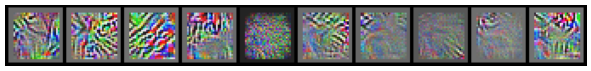

['layer1.0.conv2.weight.56', 'layer1.0.conv2.weight.57', 'layer1.0.conv2.weight.58', 'layer1.0.conv2.weight.59', 'layer1.0.conv2.weight.60', 'layer1.0.conv2.weight.61', 'layer1.0.conv2.weight.62', 'layer1.0.conv2.weight.63', 'layer1.1.conv1.weight.0', 'layer1.1.conv1.weight.1']


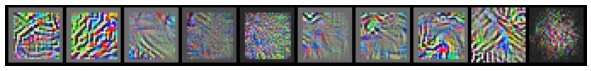

['layer1.1.conv1.weight.2', 'layer1.1.conv1.weight.3', 'layer1.1.conv1.weight.4', 'layer1.1.conv1.weight.5', 'layer1.1.conv1.weight.6', 'layer1.1.conv1.weight.7', 'layer1.1.conv1.weight.8', 'layer1.1.conv1.weight.9', 'layer1.1.conv1.weight.10', 'layer1.1.conv1.weight.11']


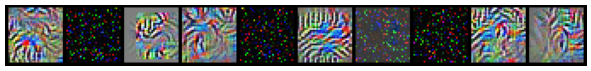

['layer1.1.conv1.weight.12', 'layer1.1.conv1.weight.13', 'layer1.1.conv1.weight.14', 'layer1.1.conv1.weight.15', 'layer1.1.conv1.weight.16', 'layer1.1.conv1.weight.17', 'layer1.1.conv1.weight.18', 'layer1.1.conv1.weight.19', 'layer1.1.conv1.weight.20', 'layer1.1.conv1.weight.21']


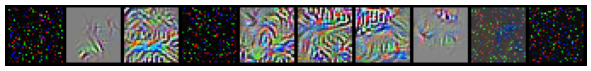

['layer1.1.conv1.weight.22', 'layer1.1.conv1.weight.23', 'layer1.1.conv1.weight.24', 'layer1.1.conv1.weight.25', 'layer1.1.conv1.weight.26', 'layer1.1.conv1.weight.27', 'layer1.1.conv1.weight.28', 'layer1.1.conv1.weight.29', 'layer1.1.conv1.weight.30', 'layer1.1.conv1.weight.31']


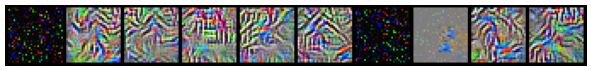

['layer1.1.conv1.weight.32', 'layer1.1.conv1.weight.33', 'layer1.1.conv1.weight.34', 'layer1.1.conv1.weight.35', 'layer1.1.conv1.weight.36', 'layer1.1.conv1.weight.37', 'layer1.1.conv1.weight.38', 'layer1.1.conv1.weight.39', 'layer1.1.conv1.weight.40', 'layer1.1.conv1.weight.41']


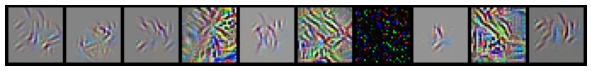

['layer1.1.conv1.weight.42', 'layer1.1.conv1.weight.43', 'layer1.1.conv1.weight.44', 'layer1.1.conv1.weight.45', 'layer1.1.conv1.weight.46', 'layer1.1.conv1.weight.47', 'layer1.1.conv1.weight.48', 'layer1.1.conv1.weight.49', 'layer1.1.conv1.weight.50', 'layer1.1.conv1.weight.51']


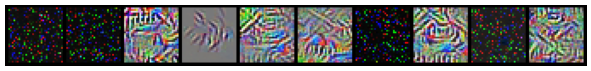

['layer1.1.conv1.weight.52', 'layer1.1.conv1.weight.53', 'layer1.1.conv1.weight.54', 'layer1.1.conv1.weight.55', 'layer1.1.conv1.weight.56', 'layer1.1.conv1.weight.57', 'layer1.1.conv1.weight.58', 'layer1.1.conv1.weight.59', 'layer1.1.conv1.weight.60', 'layer1.1.conv1.weight.61']


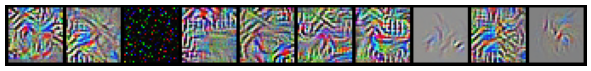

['layer1.1.conv1.weight.62', 'layer1.1.conv1.weight.63', 'layer1.1.conv2.weight.0', 'layer1.1.conv2.weight.1', 'layer1.1.conv2.weight.2', 'layer1.1.conv2.weight.3', 'layer1.1.conv2.weight.4', 'layer1.1.conv2.weight.5', 'layer1.1.conv2.weight.6', 'layer1.1.conv2.weight.7']


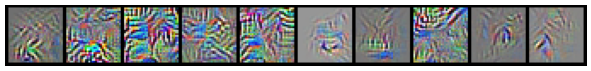

['layer1.1.conv2.weight.8', 'layer1.1.conv2.weight.9', 'layer1.1.conv2.weight.10', 'layer1.1.conv2.weight.11', 'layer1.1.conv2.weight.12', 'layer1.1.conv2.weight.13', 'layer1.1.conv2.weight.14', 'layer1.1.conv2.weight.15', 'layer1.1.conv2.weight.16', 'layer1.1.conv2.weight.17']


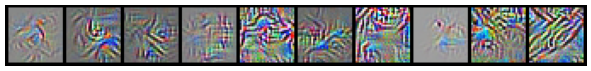

Saving results at 200
[('layer1.0.conv2.weight.16', 1935.83154296875), ('layer1.0.conv2.weight.24', 1690.9774169921875), ('layer1.0.conv2.weight.38', 1636.090576171875), ('layer1.0.conv1.weight.42', 1523.22119140625), ('layer1.0.conv2.weight.12', 1468.628173828125), ('layer1.0.conv2.weight.47', 1400.906494140625), ('layer1.0.conv1.weight.52', 1333.0986328125), ('layer1.0.conv1.weight.10', 1326.197021484375), ('layer1.0.conv1.weight.14', 1316.9493408203125), ('layer1.0.conv2.weight.48', 1282.136474609375), ('layer1.0.conv1.weight.51', 1268.247802734375), ('layer1.0.conv1.weight.23', 1258.9888916015625), ('layer1.0.conv2.weight.22', 1208.8236083984375), ('layer1.1.conv1.weight.18', 1181.960205078125), ('layer1.0.conv2.weight.5', 1177.46533203125), ('layer1.0.conv2.weight.21', 1137.974609375), ('layer1.1.conv1.weight.26', 1128.742431640625), ('layer1.1.conv2.weight.0', 1092.02587890625), ('layer1.1.conv2.weight.12', 1059.38427734375), ('layer1.0.conv2.weight.14', 1015.3340454101562), ('la

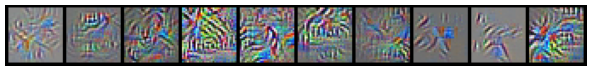

['layer1.1.conv2.weight.28', 'layer1.1.conv2.weight.29', 'layer1.1.conv2.weight.30', 'layer1.1.conv2.weight.31', 'layer1.1.conv2.weight.32', 'layer1.1.conv2.weight.33', 'layer1.1.conv2.weight.34', 'layer1.1.conv2.weight.35', 'layer1.1.conv2.weight.36', 'layer1.1.conv2.weight.37']


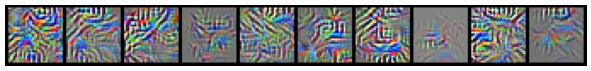

['layer1.1.conv2.weight.38', 'layer1.1.conv2.weight.39', 'layer1.1.conv2.weight.40', 'layer1.1.conv2.weight.41', 'layer1.1.conv2.weight.42', 'layer1.1.conv2.weight.43', 'layer1.1.conv2.weight.44', 'layer1.1.conv2.weight.45', 'layer1.1.conv2.weight.46', 'layer1.1.conv2.weight.47']


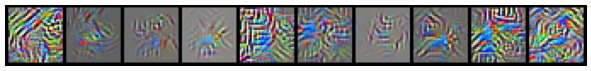

['layer1.1.conv2.weight.48', 'layer1.1.conv2.weight.49', 'layer1.1.conv2.weight.50', 'layer1.1.conv2.weight.51', 'layer1.1.conv2.weight.52', 'layer1.1.conv2.weight.53', 'layer1.1.conv2.weight.54', 'layer1.1.conv2.weight.55', 'layer1.1.conv2.weight.56', 'layer1.1.conv2.weight.57']


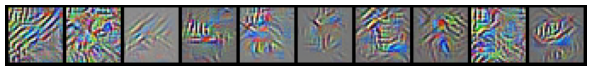

['layer1.1.conv2.weight.58', 'layer1.1.conv2.weight.59', 'layer1.1.conv2.weight.60', 'layer1.1.conv2.weight.61', 'layer1.1.conv2.weight.62', 'layer1.1.conv2.weight.63', 'layer2.0.conv1.weight.0', 'layer2.0.conv1.weight.1', 'layer2.0.conv1.weight.2', 'layer2.0.conv1.weight.3']


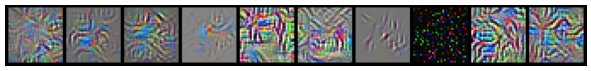

['layer2.0.conv1.weight.4', 'layer2.0.conv1.weight.5', 'layer2.0.conv1.weight.6', 'layer2.0.conv1.weight.7', 'layer2.0.conv1.weight.8', 'layer2.0.conv1.weight.9', 'layer2.0.conv1.weight.10', 'layer2.0.conv1.weight.11', 'layer2.0.conv1.weight.12', 'layer2.0.conv1.weight.13']


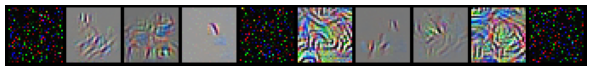

['layer2.0.conv1.weight.14', 'layer2.0.conv1.weight.15', 'layer2.0.conv1.weight.16', 'layer2.0.conv1.weight.17', 'layer2.0.conv1.weight.18', 'layer2.0.conv1.weight.19', 'layer2.0.conv1.weight.20', 'layer2.0.conv1.weight.21', 'layer2.0.conv1.weight.22', 'layer2.0.conv1.weight.23']


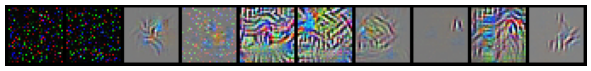

['layer2.0.conv1.weight.24', 'layer2.0.conv1.weight.25', 'layer2.0.conv1.weight.26', 'layer2.0.conv1.weight.27', 'layer2.0.conv1.weight.28', 'layer2.0.conv1.weight.29', 'layer2.0.conv1.weight.30', 'layer2.0.conv1.weight.31', 'layer2.0.conv1.weight.32', 'layer2.0.conv1.weight.33']


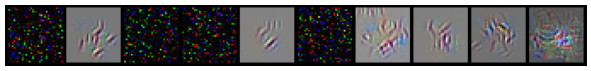

['layer2.0.conv1.weight.34', 'layer2.0.conv1.weight.35', 'layer2.0.conv1.weight.36', 'layer2.0.conv1.weight.37', 'layer2.0.conv1.weight.38', 'layer2.0.conv1.weight.39', 'layer2.0.conv1.weight.40', 'layer2.0.conv1.weight.41', 'layer2.0.conv1.weight.42', 'layer2.0.conv1.weight.43']


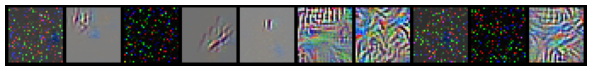

['layer2.0.conv1.weight.44', 'layer2.0.conv1.weight.45', 'layer2.0.conv1.weight.46', 'layer2.0.conv1.weight.47', 'layer2.0.conv1.weight.48', 'layer2.0.conv1.weight.49', 'layer2.0.conv1.weight.50', 'layer2.0.conv1.weight.51', 'layer2.0.conv1.weight.52', 'layer2.0.conv1.weight.53']


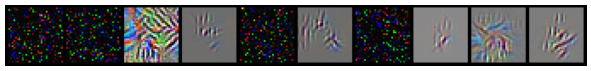

Saving results at 300
[('layer1.0.conv2.weight.16', 1935.83154296875), ('layer1.0.conv2.weight.24', 1690.9774169921875), ('layer1.0.conv2.weight.38', 1636.090576171875), ('layer2.0.conv1.weight.39', 1526.3179931640625), ('layer1.0.conv1.weight.42', 1523.22119140625), ('layer1.0.conv2.weight.12', 1468.628173828125), ('layer2.0.conv1.weight.18', 1424.994384765625), ('layer1.0.conv2.weight.47', 1400.906494140625), ('layer1.0.conv1.weight.52', 1333.0986328125), ('layer1.0.conv1.weight.10', 1326.197021484375), ('layer1.0.conv1.weight.14', 1316.9493408203125), ('layer1.0.conv2.weight.48', 1282.136474609375), ('layer2.0.conv1.weight.46', 1275.045654296875), ('layer1.0.conv1.weight.51', 1268.247802734375), ('layer1.0.conv1.weight.23', 1258.9888916015625), ('layer1.0.conv2.weight.22', 1208.8236083984375), ('layer1.1.conv1.weight.18', 1181.960205078125), ('layer1.0.conv2.weight.5', 1177.46533203125), ('layer1.0.conv2.weight.21', 1137.974609375), ('layer1.1.conv1.weight.26', 1128.742431640625), (

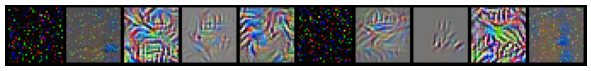

['layer2.0.conv1.weight.64', 'layer2.0.conv1.weight.65', 'layer2.0.conv1.weight.66', 'layer2.0.conv1.weight.67', 'layer2.0.conv1.weight.68', 'layer2.0.conv1.weight.69', 'layer2.0.conv1.weight.70', 'layer2.0.conv1.weight.71', 'layer2.0.conv1.weight.72', 'layer2.0.conv1.weight.73']


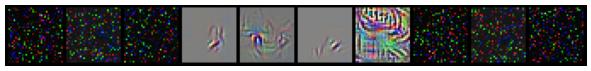

['layer2.0.conv1.weight.74', 'layer2.0.conv1.weight.75', 'layer2.0.conv1.weight.76', 'layer2.0.conv1.weight.77', 'layer2.0.conv1.weight.78', 'layer2.0.conv1.weight.79', 'layer2.0.conv1.weight.80', 'layer2.0.conv1.weight.81', 'layer2.0.conv1.weight.82', 'layer2.0.conv1.weight.83']


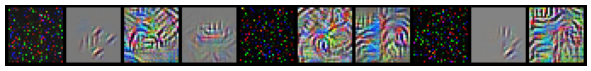

['layer2.0.conv1.weight.84', 'layer2.0.conv1.weight.85', 'layer2.0.conv1.weight.86', 'layer2.0.conv1.weight.87', 'layer2.0.conv1.weight.88', 'layer2.0.conv1.weight.89', 'layer2.0.conv1.weight.90', 'layer2.0.conv1.weight.91', 'layer2.0.conv1.weight.92', 'layer2.0.conv1.weight.93']


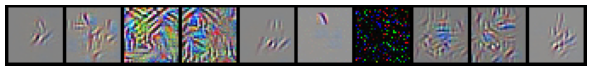

['layer2.0.conv1.weight.94', 'layer2.0.conv1.weight.95', 'layer2.0.conv1.weight.96', 'layer2.0.conv1.weight.97', 'layer2.0.conv1.weight.98', 'layer2.0.conv1.weight.99', 'layer2.0.conv1.weight.100', 'layer2.0.conv1.weight.101', 'layer2.0.conv1.weight.102', 'layer2.0.conv1.weight.103']


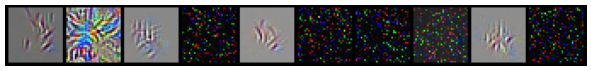

['layer2.0.conv1.weight.104', 'layer2.0.conv1.weight.105', 'layer2.0.conv1.weight.106', 'layer2.0.conv1.weight.107', 'layer2.0.conv1.weight.108', 'layer2.0.conv1.weight.109', 'layer2.0.conv1.weight.110', 'layer2.0.conv1.weight.111', 'layer2.0.conv1.weight.112', 'layer2.0.conv1.weight.113']


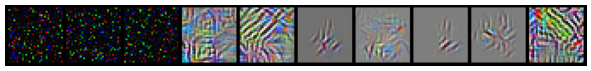

['layer2.0.conv1.weight.114', 'layer2.0.conv1.weight.115', 'layer2.0.conv1.weight.116', 'layer2.0.conv1.weight.117', 'layer2.0.conv1.weight.118', 'layer2.0.conv1.weight.119', 'layer2.0.conv1.weight.120', 'layer2.0.conv1.weight.121', 'layer2.0.conv1.weight.122', 'layer2.0.conv1.weight.123']


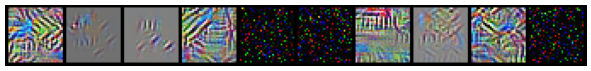

['layer2.0.conv1.weight.124', 'layer2.0.conv1.weight.125', 'layer2.0.conv1.weight.126', 'layer2.0.conv1.weight.127', 'layer2.0.conv2.weight.0', 'layer2.0.conv2.weight.1', 'layer2.0.conv2.weight.2', 'layer2.0.conv2.weight.3', 'layer2.0.conv2.weight.4', 'layer2.0.conv2.weight.5']


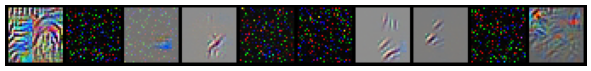

['layer2.0.conv2.weight.6', 'layer2.0.conv2.weight.7', 'layer2.0.conv2.weight.8', 'layer2.0.conv2.weight.9', 'layer2.0.conv2.weight.10', 'layer2.0.conv2.weight.11', 'layer2.0.conv2.weight.12', 'layer2.0.conv2.weight.13', 'layer2.0.conv2.weight.14', 'layer2.0.conv2.weight.15']


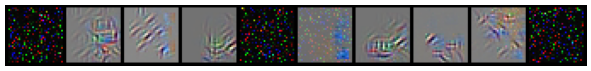

['layer2.0.conv2.weight.16', 'layer2.0.conv2.weight.17', 'layer2.0.conv2.weight.18', 'layer2.0.conv2.weight.19', 'layer2.0.conv2.weight.20', 'layer2.0.conv2.weight.21', 'layer2.0.conv2.weight.22', 'layer2.0.conv2.weight.23', 'layer2.0.conv2.weight.24', 'layer2.0.conv2.weight.25']


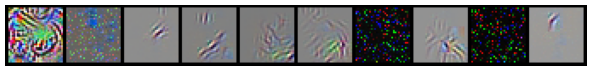

Saving results at 400
[('layer2.0.conv2.weight.16', 2573.631103515625), ('layer1.0.conv2.weight.16', 1935.83154296875), ('layer1.0.conv2.weight.24', 1690.9774169921875), ('layer1.0.conv2.weight.38', 1636.090576171875), ('layer2.0.conv1.weight.120', 1588.857666015625), ('layer2.0.conv1.weight.39', 1526.3179931640625), ('layer1.0.conv1.weight.42', 1523.22119140625), ('layer1.0.conv2.weight.12', 1468.628173828125), ('layer2.0.conv1.weight.18', 1424.994384765625), ('layer1.0.conv2.weight.47', 1400.906494140625), ('layer2.0.conv1.weight.62', 1368.2825927734375), ('layer1.0.conv1.weight.52', 1333.0986328125), ('layer1.0.conv1.weight.10', 1326.197021484375), ('layer1.0.conv1.weight.14', 1316.9493408203125), ('layer2.0.conv1.weight.83', 1297.801513671875), ('layer1.0.conv2.weight.48', 1282.136474609375), ('layer2.0.conv1.weight.46', 1275.045654296875), ('layer1.0.conv1.weight.51', 1268.247802734375), ('layer1.0.conv1.weight.23', 1258.9888916015625), ('layer2.0.conv1.weight.108', 1232.731811523

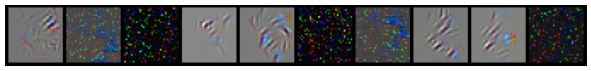

['layer2.0.conv2.weight.36', 'layer2.0.conv2.weight.37', 'layer2.0.conv2.weight.38', 'layer2.0.conv2.weight.39', 'layer2.0.conv2.weight.40', 'layer2.0.conv2.weight.41', 'layer2.0.conv2.weight.42', 'layer2.0.conv2.weight.43', 'layer2.0.conv2.weight.44', 'layer2.0.conv2.weight.45']


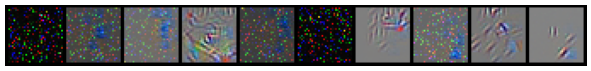

['layer2.0.conv2.weight.46', 'layer2.0.conv2.weight.47', 'layer2.0.conv2.weight.48', 'layer2.0.conv2.weight.49', 'layer2.0.conv2.weight.50', 'layer2.0.conv2.weight.51', 'layer2.0.conv2.weight.52', 'layer2.0.conv2.weight.53', 'layer2.0.conv2.weight.54', 'layer2.0.conv2.weight.55']


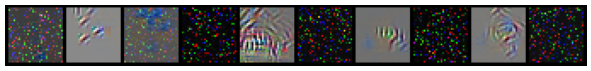

['layer2.0.conv2.weight.56', 'layer2.0.conv2.weight.57', 'layer2.0.conv2.weight.58', 'layer2.0.conv2.weight.59', 'layer2.0.conv2.weight.60', 'layer2.0.conv2.weight.61', 'layer2.0.conv2.weight.62', 'layer2.0.conv2.weight.63', 'layer2.0.conv2.weight.64', 'layer2.0.conv2.weight.65']


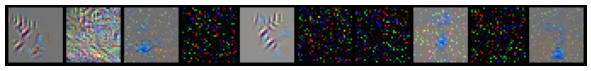

['layer2.0.conv2.weight.66', 'layer2.0.conv2.weight.67', 'layer2.0.conv2.weight.68', 'layer2.0.conv2.weight.69', 'layer2.0.conv2.weight.70', 'layer2.0.conv2.weight.71', 'layer2.0.conv2.weight.72', 'layer2.0.conv2.weight.73', 'layer2.0.conv2.weight.74', 'layer2.0.conv2.weight.75']


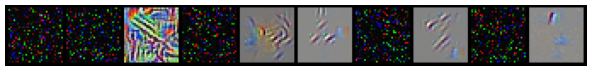

['layer2.0.conv2.weight.76', 'layer2.0.conv2.weight.77', 'layer2.0.conv2.weight.78', 'layer2.0.conv2.weight.79', 'layer2.0.conv2.weight.80', 'layer2.0.conv2.weight.81', 'layer2.0.conv2.weight.82', 'layer2.0.conv2.weight.83', 'layer2.0.conv2.weight.84', 'layer2.0.conv2.weight.85']


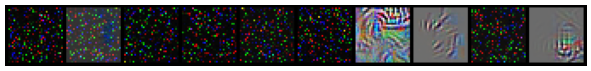

['layer2.0.conv2.weight.86', 'layer2.0.conv2.weight.87', 'layer2.0.conv2.weight.88', 'layer2.0.conv2.weight.89', 'layer2.0.conv2.weight.90', 'layer2.0.conv2.weight.91', 'layer2.0.conv2.weight.92', 'layer2.0.conv2.weight.93', 'layer2.0.conv2.weight.94', 'layer2.0.conv2.weight.95']


In [31]:
neurons_results =  []

for i in range(0, len(conv_neurons), 10):
    section = conv_neurons[i:i+10]
    print(section)
    _results = render_multiple(model, *section, thresholds=[256], device="cuda:0", verbose=False)
    show_images(*[images[-1] for (images, _) in _results], dpi=50)
    neurons_results.extend(_results)

    if i % 100 == 0:
        print(f"Saving results at {i}")
        torch.save(neurons_results, "../visualizations/restnet-cifar10.pt")
        
        # Print the 100 most activated neurons
        print([(name, activation) for (name, (_, activation)) in sorted(zip(conv_neurons, neurons_results), key=lambda x: x[1][1], reverse=True)[:100]])

### Developmental analysis of a sample neuron

In [ ]:
sample_neuron = "layer1.1.conv1.weights.7"
viz, activation = render(model, sample_neuron, seed=0)[-1]
print(activation)
show_image(viz)

In [ ]:
pbar = tqdm(checkpoints, desc="Looping checkpoints (activation: ???)")
activations = []

for state_dict in pbar:
    model.load_state_dict(state_dict)
    extractor = ActivationExtractor(model, sample_neuron)
    handle = extractor.register_hook()

    model.eval()
    with torch.no_grad():
        model(viz) 
        activations.append(extractor.activation)
    
    pbar.set_description(f"Looping checkpoints (activation: {extractor.activation.item():.2f})")

In [ ]:
plt.plot([b for (_, b) in checkpoints.checkpoints][-5:], activations[-5:])
plt.xlabel("Training step")
plt.ylabel("Activation")

In [ ]:
# Let's do feature visualization at the very start, at 90  steps (where it reaches a minimum) at 5k steps where it's close to 0, at 8600, at 9000, and at the last step. 

# First let's get the closest checkpoints to these steps

ideal_checkpoint_steps = [90, 5000, 8600, 9000, 9999]

def get_closest_checkpoint(checkpoints: list[tuple[int, int]], step: int) -> int:
    return min([chkpt for chkpt in checkpoints], key=lambda x: abs(x[1] - step))

checkpoint_steps = [get_closest_checkpoint(checkpoints.checkpoints, step) for step in ideal_checkpoint_steps]
checkpoint_steps

In [ ]:
for (epoch, batch_idx) in tqdm(checkpoint_steps, desc="Going through checkpoints"):
    model.load_state_dict(checkpoints[(epoch, batch_idx)])
    vizs, activation = render(model, sample_neuron, seed=0, thresholds=[0, 64, 128, 256, 512], verbose=True)
    show_images(*vizs)

In [ ]:
def evolve_multiple(model: nn.Module, checkpoints: CheckpointManager, *locations: str, opt_steps: int = 512, verbose: bool = True, init_seed: int = 0):
    model.load_state_dict(checkpoints[-1])
    model.eval()

    final_vizs: dict[str, torch.Tensor] = {}
    visz: dict[tuple[str], list[torch.Tensor]] = {}
    activations: dict[str, list[float]] = {}
   
    # Create the visualizations for the last checkpoint
    for location, _location_viz in tqdm(zip(locations, render_multiple(model, *locations, thresholds=[opt_steps], verbose=verbose, init_seed=init_seed)), desc="Creating initial visualizations"):
        final_vizs[location] = _location_viz[0][0]
        visz[location] = []
        activations[location] = []

    for i, state_dict in tqdm(enumerate(checkpoints), desc="Visiting checkpoints"):
        batch_idx = checkpoints.checkpoints[i][1]

        # Render the visualization for the next checkpoint
        model.load_state_dict(checkpoint)
        activations = []

        for location in locations:
            viz = final_vizs[location]

            model.load_state_dict(state_dict)
            extractor = ActivationExtractor(model, location)
            handle = extractor.register_hook()

            with torch.no_grad():
                model(viz) 
                activations[location].append(extractor.activation.item())

            handle.remove()

        wandb.log({f"activations/{location}": activations[location][-1] for location in locations}, step=batch_idx)
            
        # Visualize this checkpoint
        if i % 20 or i == len(checkpoints) - 1:
            for location, _location_viz in tqdm(zip(locations, render_multiple(model, *locations, thresholds=[opt_steps], verbose=verbose, init_seed=init_seed)), desc=f"Creating visualizations for batch {batch_idx}"):
                viz = location_vizs[0][0]
                vizs[location].append(viz)
                image_np = gen_image(viz)
                image = wandb.Image(image_np, caption=f"Optimized {location} at batch {batch_idx}")

                wandb.log({f"visualizations/{location}": image for location in locations}, step=batch_idx)

    return visz, activations


In [ ]:
locations = [
    'layer1.1.conv1.weight.1',
    'layer1.1.conv1.weight.4',
    'layer1.1.conv1.weight.7',
    'layer1.1.conv2.weight.1',
    'layer1.1.conv2.weight.4',
    'layer1.1.conv2.weight.7',
    'layer2.1.conv1.weight.1',
    'layer2.1.conv1.weight.4',
    'layer2.1.conv1.weight.7',
    'layer2.1.conv2.weight.1',
    'layer2.1.conv2.weight.4',
    'layer2.1.conv2.weight.7',
]

wandb.finish()
# run_id = input("Run ID: ")
# wandb.init(project=config.project, entity=config.entity, id=run_id, resume="must")
results = evolve_multiple(model, checkpoints, *locations)